# Import Necessary Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Function for loading and preprocessing the MNIST dataset

In [2]:
def load_and_preprocess_data():

    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # train_images = train_images / 255.0
    # test_images = test_images / 255.0

    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)

    val_size = int(0.1 * len(train_images))
    val_images, val_labels = train_images[:val_size], train_labels[:val_size]
    train_images, train_labels = train_images[val_size:], train_labels[val_size:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

# Function for Geometric Augmentation

In [3]:
def geometric_augmentation(images, batch_size):

    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
    )

    augmented_data_gen = datagen.flow(images, batch_size=batch_size, shuffle=False)

    augmented_images = []

    num_batches = int(np.ceil(len(images) / batch_size))

    for _ in range(num_batches):
        images_batch = next(augmented_data_gen)
        augmented_images.append(images_batch)


    augmented_images = np.concatenate(augmented_images, axis=0)

    return augmented_images

# Function for Photometric augmentation using Datagen

In [4]:
def photometric_augmentation(images, batch_size):

    datagen = ImageDataGenerator(
        brightness_range=[0.5, 1.5],
    )

    augmented_data_gen = datagen.flow(images, batch_size=batch_size, shuffle=False)

    augmented_images = []

    num_batches = int(np.ceil(len(images) / batch_size))

    for _ in range(num_batches):
        images_batch = next(augmented_data_gen)
        augmented_images.append(images_batch)


    augmented_images = np.concatenate(augmented_images, axis=0)

    return augmented_images

# Function for Cutmix Augmentation

In [5]:
def cutmix(images, labels):

    lamda = 0.7
    total_images = len(images)
    indices = np.random.permutation(total_images)
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]

    cutmix_images = images.copy()
    cutmix_labels = labels.copy()

    for i in range(total_images):

        rx, ry = np.random.randint(images.shape[1]), np.random.randint(images.shape[2])
        rw, rh = int(images.shape[1] * np.sqrt(1 - lamda)), int(images.shape[2] * np.sqrt(1 - lamda))

        x1 = np.clip(rx - rw // 2, 0, images.shape[1])
        y1 = np.clip(ry - rh // 2, 0, images.shape[2])
        x2 = np.clip(rx + rw // 2, 0, images.shape[1])
        y2 = np.clip(ry + rh // 2, 0, images.shape[2])


        cutmix_images[i, x1:x2, y1:y2, :] = shuffled_images[i, x1:x2, y1:y2, :]
        cutmix_labels[i] = lamda * labels[i] + (1 - lamda) * shuffled_labels[i]

    return cutmix_images, cutmix_labels


# Function for mixup Augmentation

In [6]:
def mixup(images, labels):

    lamda = 0.8
    total_images = len(images)
    indices = np.random.permutation(total_images)
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]

    mixup_images = lamda * images + (1 - lamda) * shuffled_images
    mixup_labels = lamda * labels + (1 - lamda) * shuffled_labels

    return mixup_images, mixup_labels

# Function to Display some images

In [7]:
def display_images(images, labels, title):
    plt.figure(figsize=(20, 5))
    for i in range(16):
        plt.subplot(2, 8, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Splitting the images for different augmentation

In [8]:
def split_data(images, labels):

    geo_size = int(0.4 * len(images))
    photo_size = int(0.3 * len(images))
    mixup_size = int(0.15 * len(images))
    cutmix_size = len(images) - geo_size - photo_size - mixup_size

    geo_images, geo_labels = images[:geo_size], labels[:geo_size]
    photo_images, photo_labels = images[geo_size:geo_size + photo_size], labels[geo_size:geo_size + photo_size]
    mixup_images, mixup_labels = images[geo_size + photo_size:geo_size + photo_size + mixup_size], labels[geo_size + photo_size:geo_size + photo_size + mixup_size]
    cutmix_images, cutmix_labels = images[geo_size + photo_size + mixup_size:], labels[geo_size + photo_size + mixup_size:]

    return (geo_images, geo_labels), (photo_images, photo_labels), (mixup_images, mixup_labels), (cutmix_images, cutmix_labels)

# Function to perform several augmentation for dataset

In [9]:
def augment_and_append(images, labels, title):
    (geo_images, geo_labels), (photo_images, photo_labels), (mixup_images, mixup_labels), (cutmix_images, cutmix_labels) = split_data(images, labels)

    geo_augmented_images = geometric_augmentation(geo_images, batch_size=54)
    photo_augmented_images = photometric_augmentation(photo_images, batch_size=54)
    cutmix_augmented_images, cutmix_augmented_labels = cutmix(cutmix_images, cutmix_labels)
    mixup_augmented_images, mixup_augmented_labels = mixup(mixup_images, mixup_labels)

    display_images(geo_augmented_images[:16], geo_labels[:16], f'{title} Geometric Augmentation')
    display_images(photo_augmented_images[:16], photo_labels[:16], f'{title} Photometric Augmentation')
    display_images(cutmix_augmented_images[:16], cutmix_augmented_labels[:16], f'{title} CutMix Augmentation')
    display_images(mixup_augmented_images[:16], mixup_augmented_labels[:16], f'{title} MixUp Augmentation')

    # Append augmented images with the original images
    augmented_images = np.concatenate([
        images,
        geo_augmented_images,
        photo_augmented_images,
        cutmix_augmented_images,
        mixup_augmented_images
    ])

    augmented_labels = np.concatenate([
        labels,
        geo_labels,
        photo_labels,
        cutmix_augmented_labels,
        mixup_augmented_labels
    ])

    return augmented_images, augmented_labels

# Loading the MNIST preprocess data

In [10]:
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = load_and_preprocess_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Shape of the Train, Validation and Test set images before Augmentation

In [11]:
print(f"Original Training images shape: {train_images.shape}")
print(f"Original Validation images shape: {valid_images.shape}")
print(f"Original Test images shape: {test_images.shape}")

print(f"\nOriginal Training labels shape: {train_labels.shape}")
print(f"Original Validation labels shape: {valid_labels.shape}")
print(f"Original Test labels shape: {test_labels.shape}")

Original Training images shape: (54000, 28, 28, 1)
Original Validation images shape: (6000, 28, 28, 1)
Original Test images shape: (10000, 28, 28, 1)

Original Training labels shape: (54000, 10)
Original Validation labels shape: (6000, 10)
Original Test labels shape: (10000, 10)


# Plotting some sample images of the training set before Augmentation

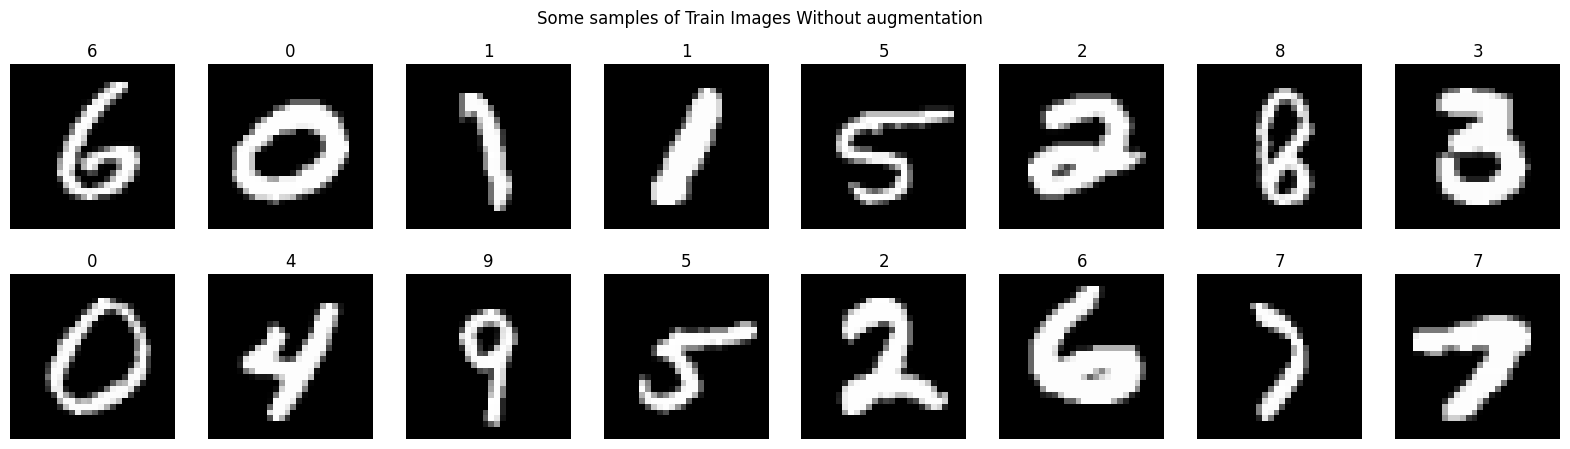

In [12]:
display_images(train_images[:16], train_labels[:16], 'Some samples of Train Images Without augmentation')

# Performing Data augmentation on the Training set and Plotting some images

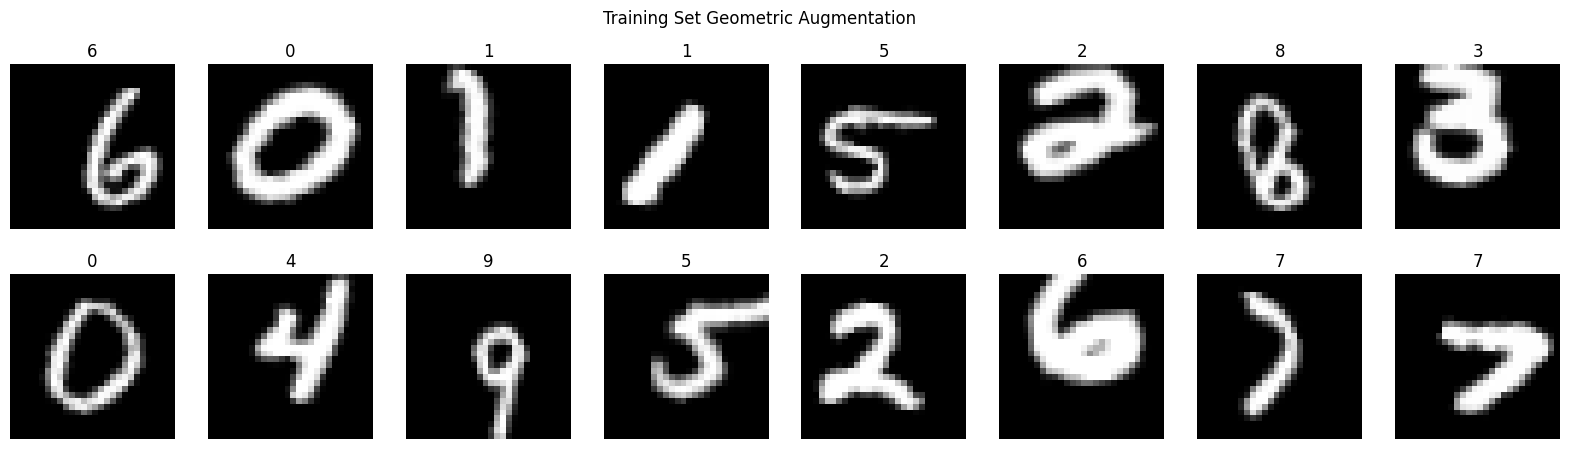

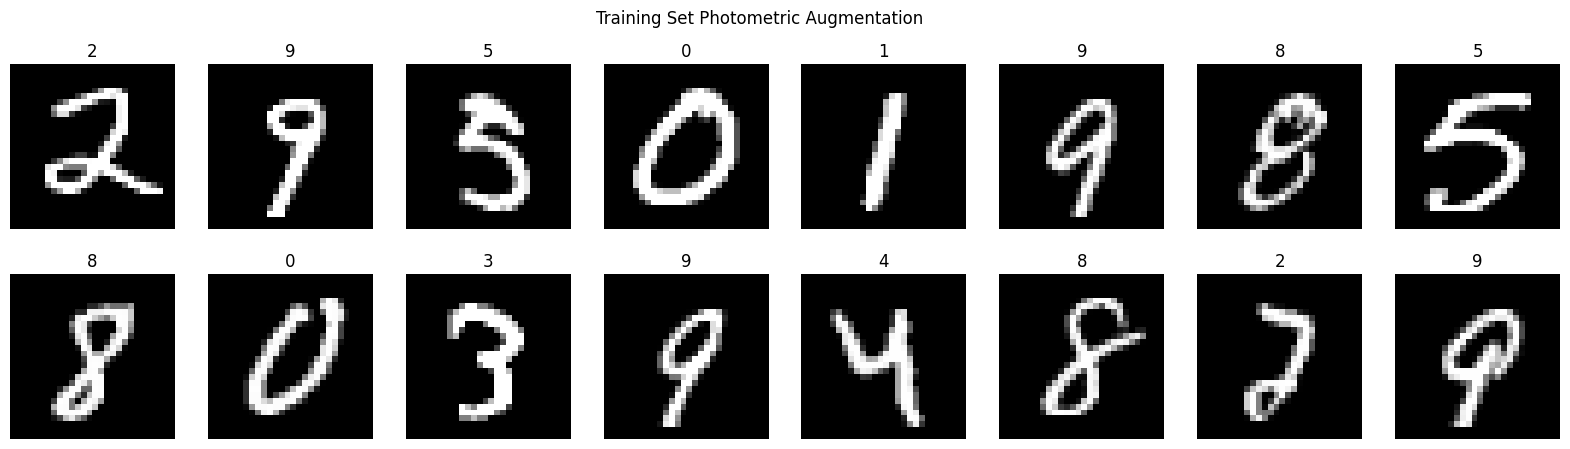

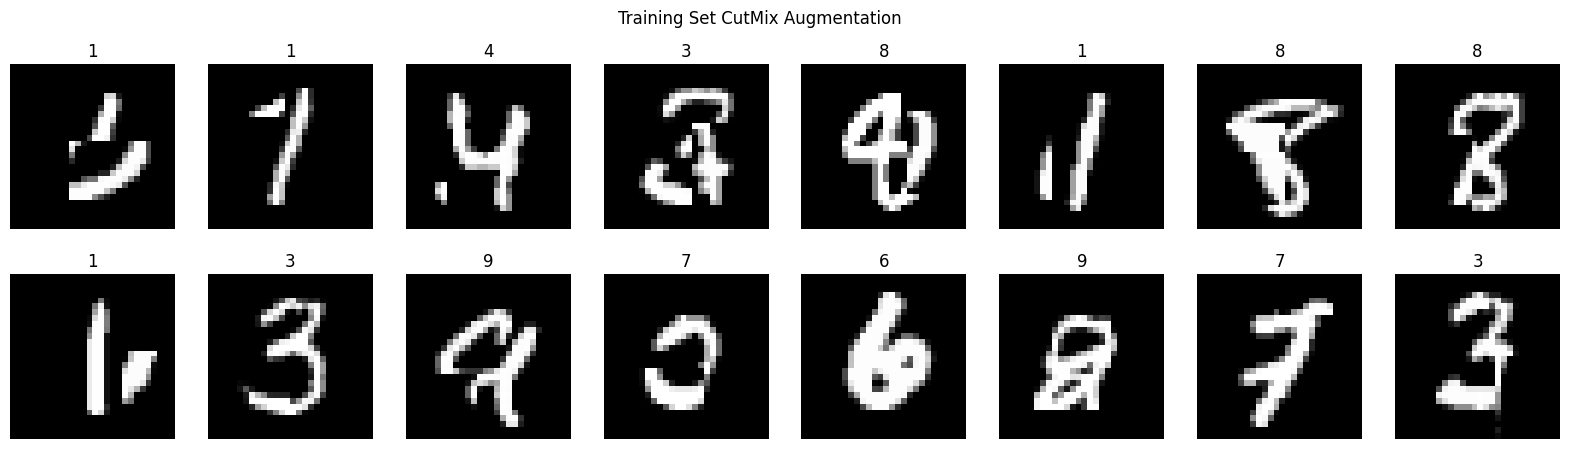

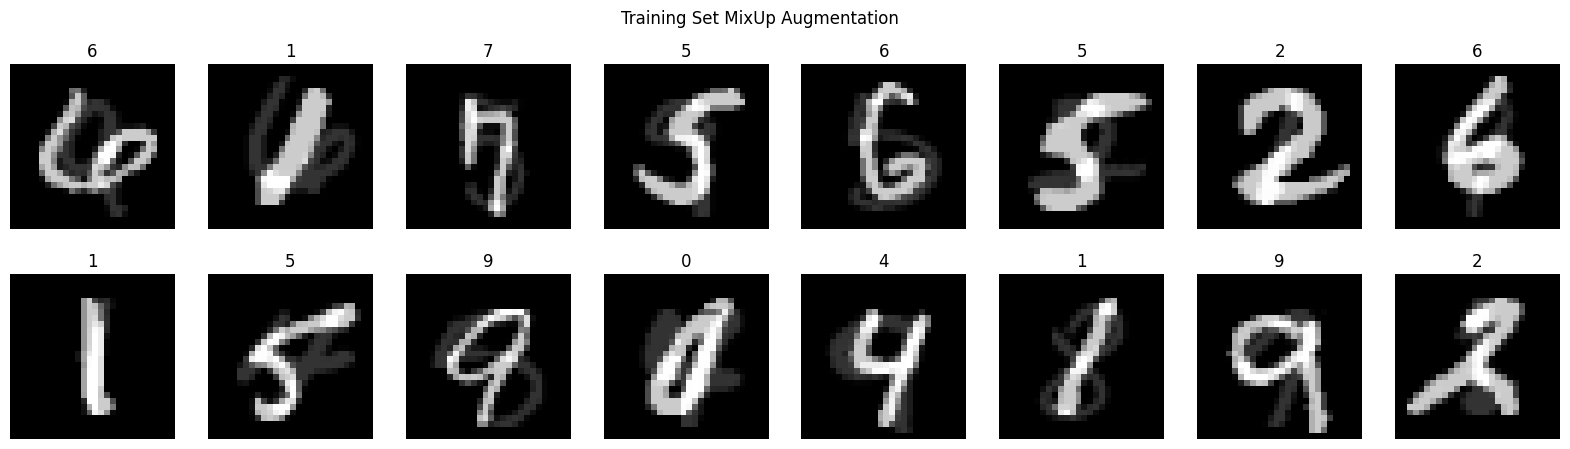

In [13]:
augmented_train_images, augmented_train_labels = augment_and_append(train_images, train_labels, 'Training Set')

# Performing Data Augmentation on the Validation set and Plotting some images

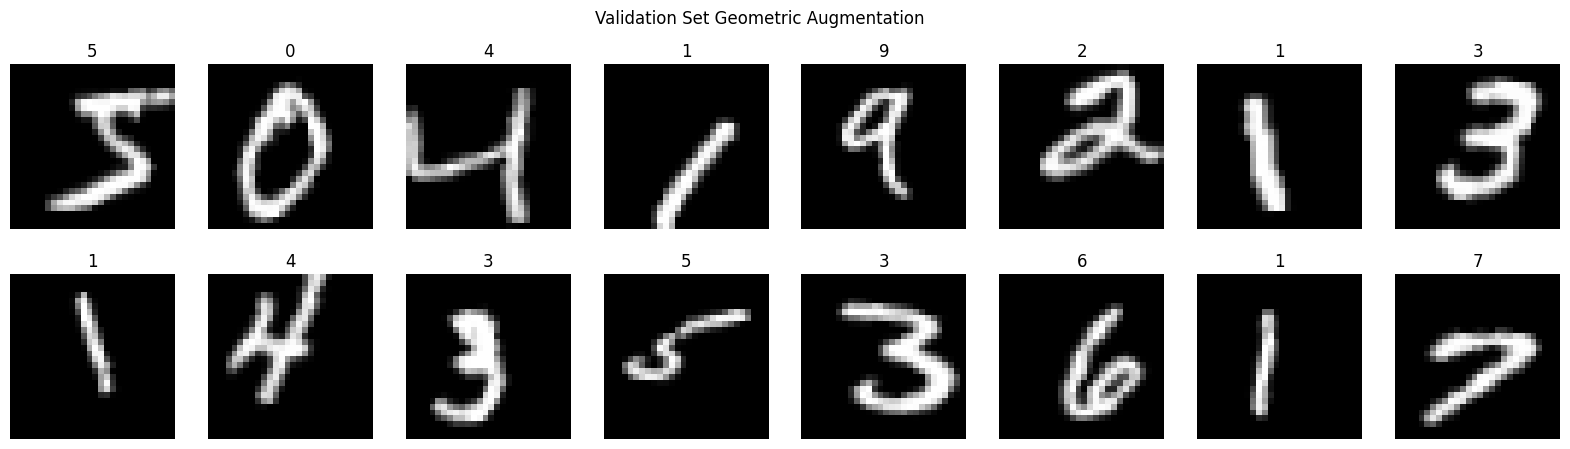

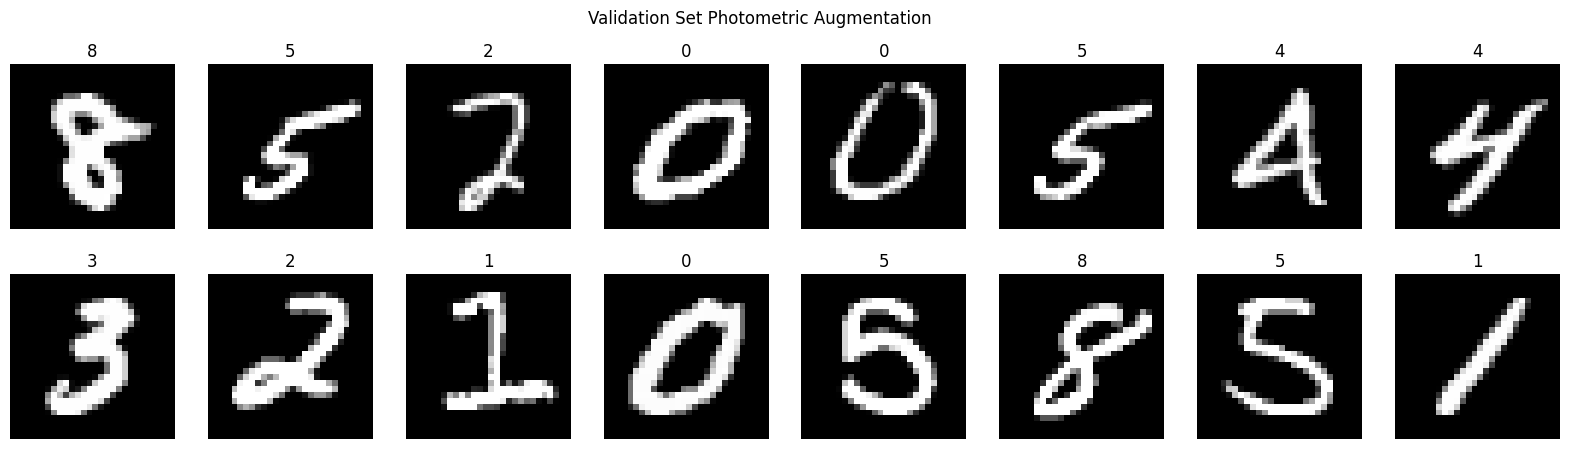

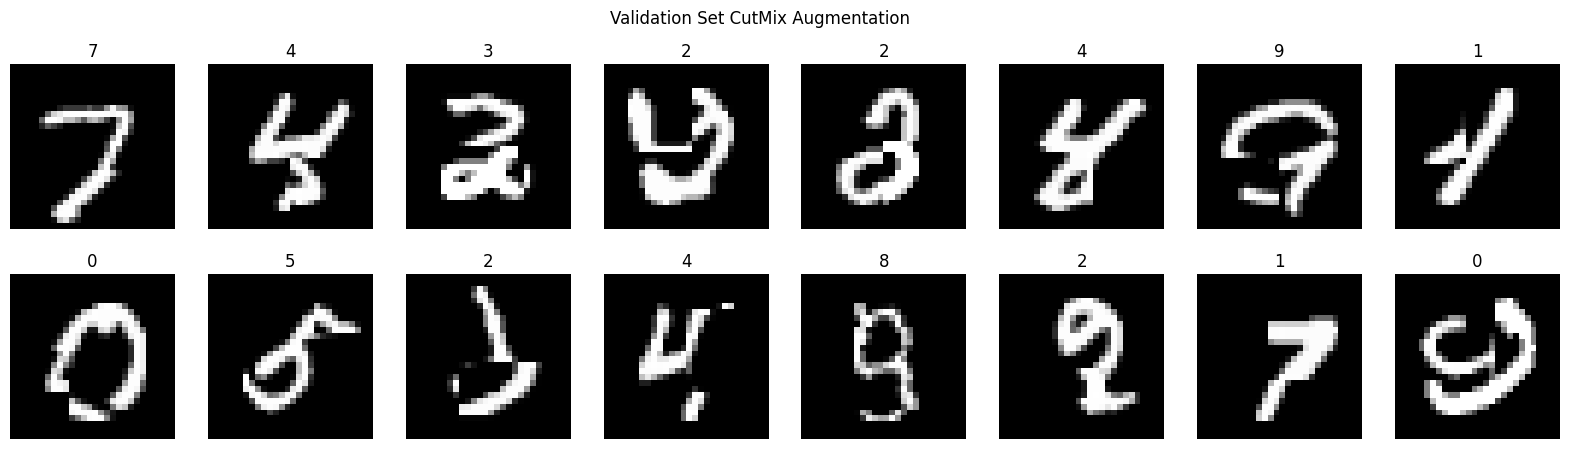

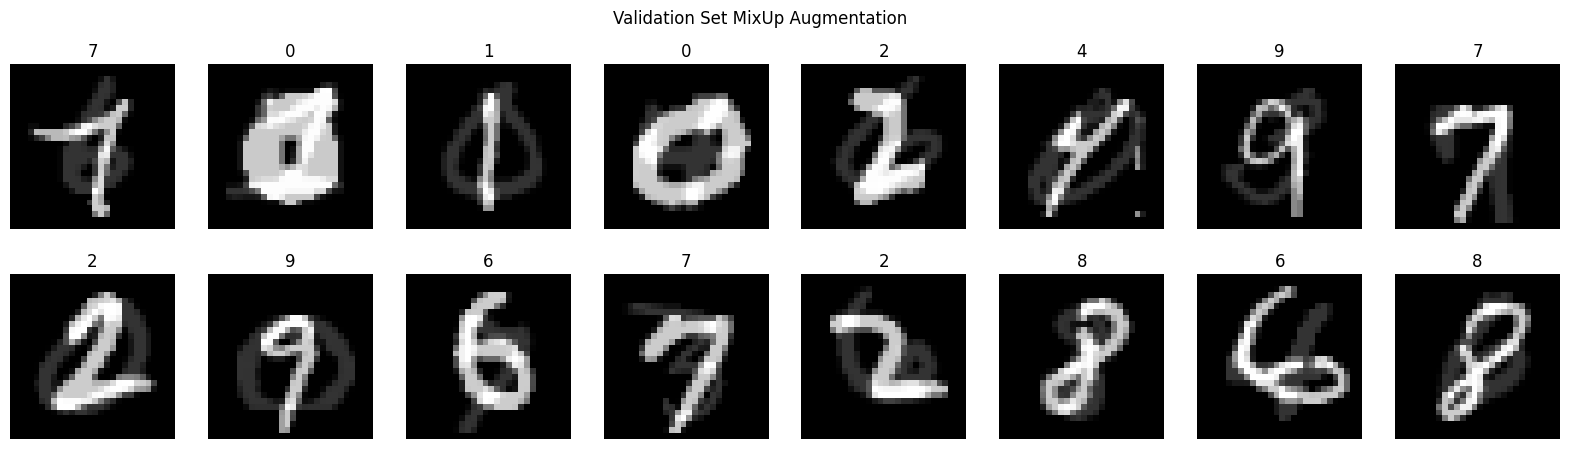

In [14]:
augmented_valid_images, augmented_valid_labels = augment_and_append(valid_images, valid_labels, 'Validation Set')

# Performing Data augmentation on the Test set and Plotting some images

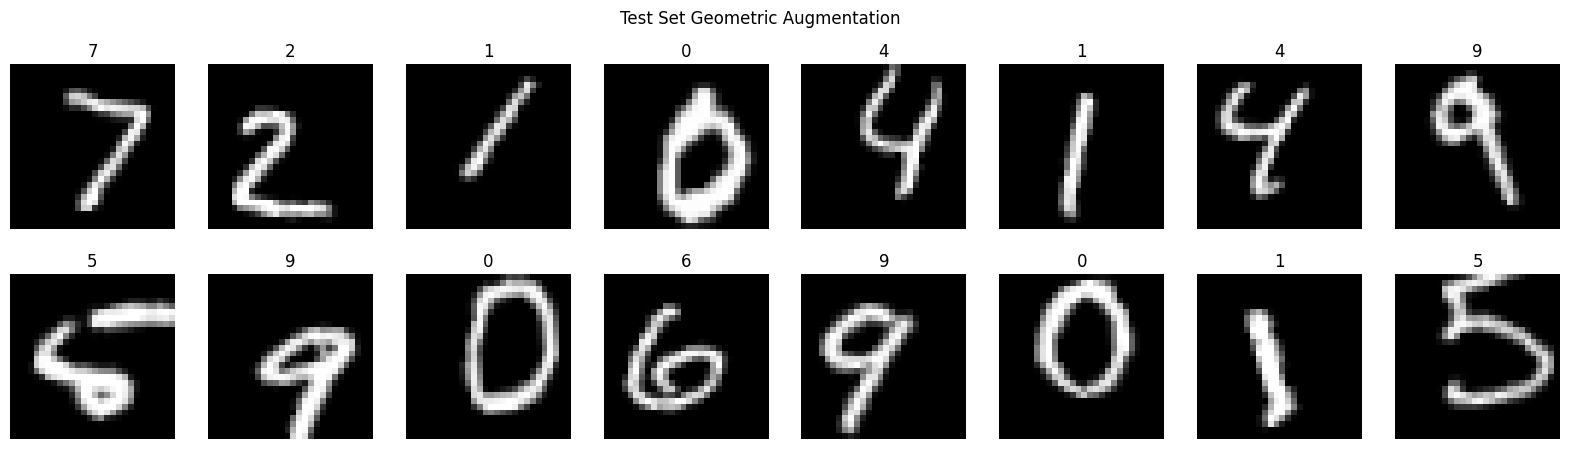

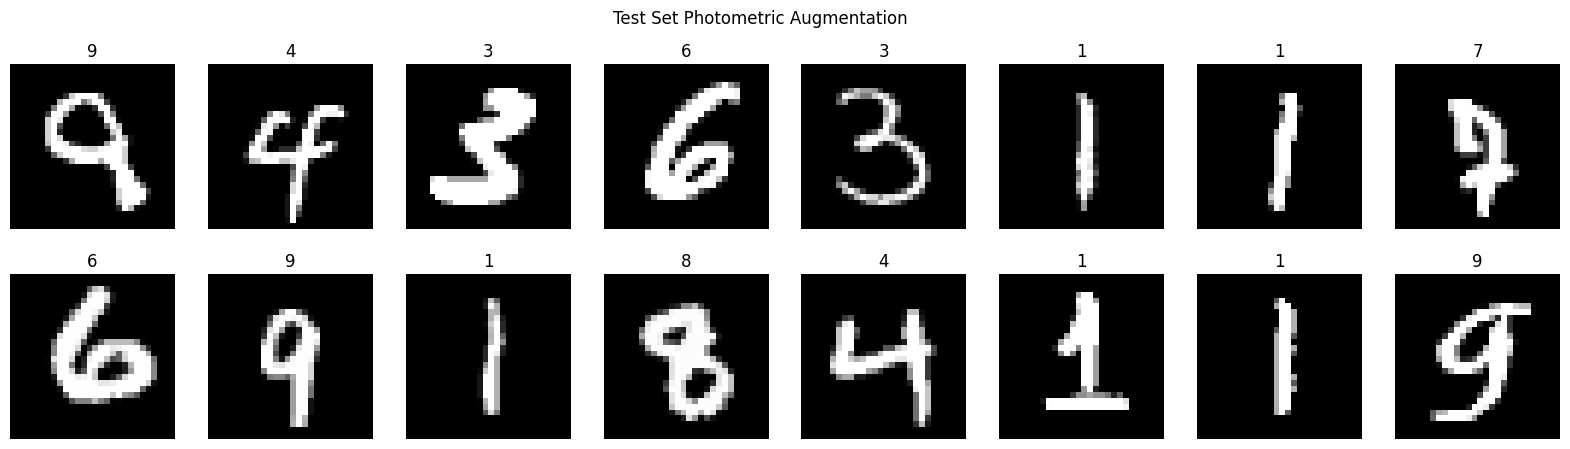

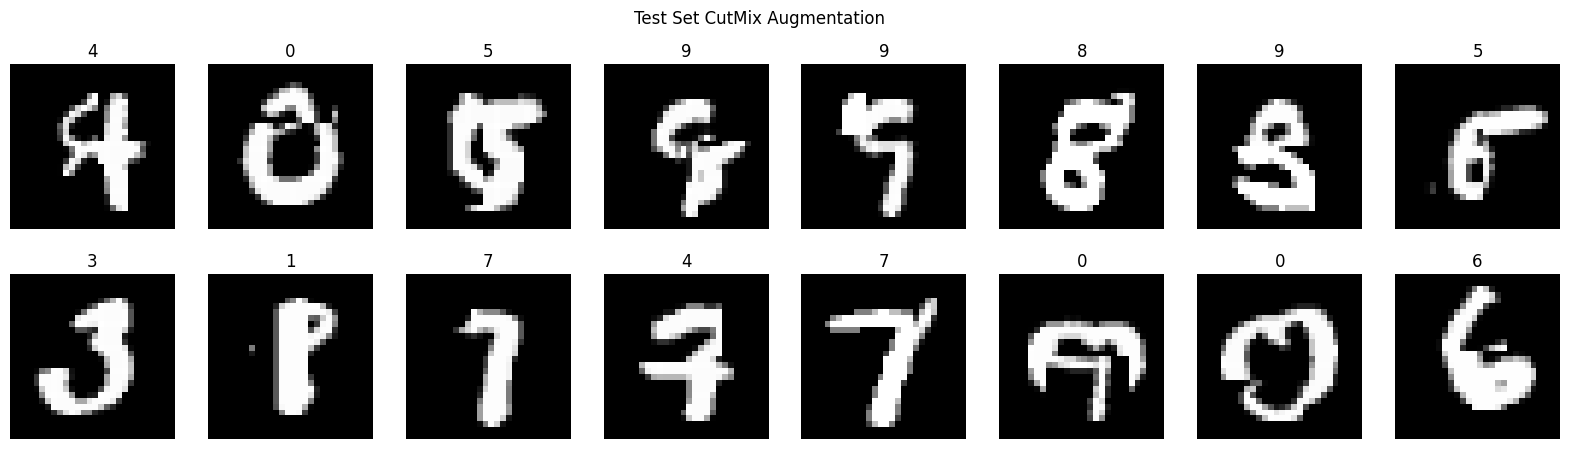

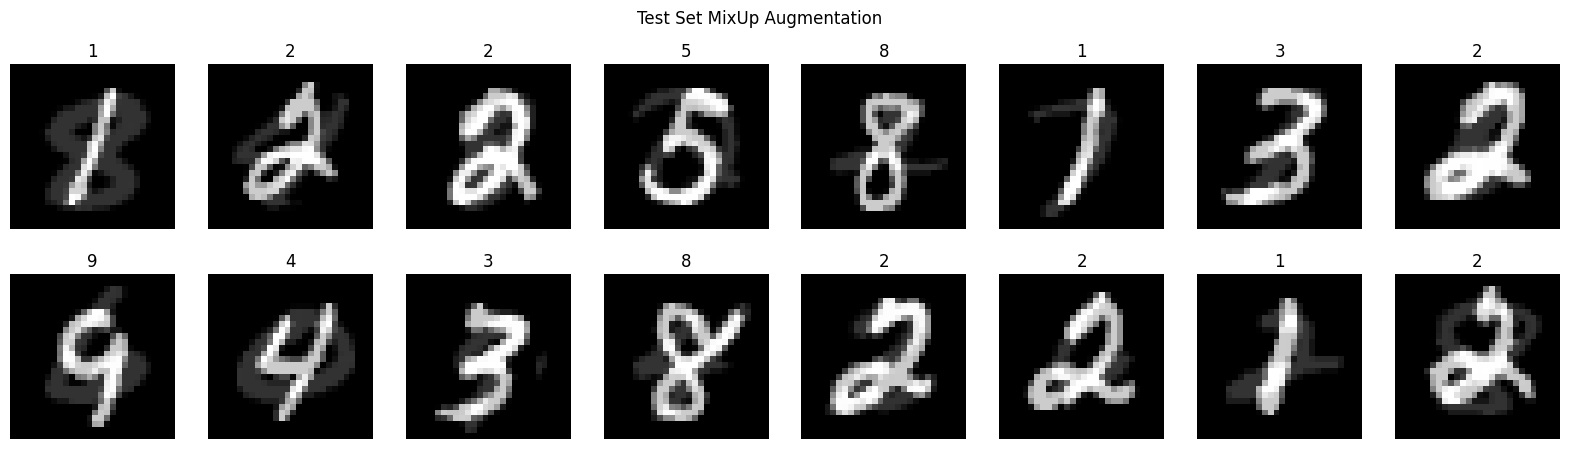

In [15]:
augmented_test_images, augmented_test_labels = augment_and_append(test_images, test_labels, 'Test Set')

# Shape of the Train, Validation and Test set images after Augmentation

In [16]:
print(f"Augmented Training images shape: {augmented_train_images.shape}")
print(f"Augmented Validation images shape: {augmented_valid_images.shape}")
print(f"Augmented Test images shape: {augmented_test_images.shape}")

print(f"\nAugmented Training labels shape: {augmented_train_labels.shape}")
print(f"Augmented Validation labels shape: {augmented_valid_labels.shape}")
print(f"Augmented Test labels shape: {augmented_test_labels.shape}")


Augmented Training images shape: (108000, 28, 28, 1)
Augmented Validation images shape: (12000, 28, 28, 1)
Augmented Test images shape: (20000, 28, 28, 1)

Augmented Training labels shape: (108000, 10)
Augmented Validation labels shape: (12000, 10)
Augmented Test labels shape: (20000, 10)


# Function to generate cnn model

In [17]:
def cnn_model(input_shape, classifier):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(1, 1)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(1, 1)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(1, 1)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(classifier, activation='softmax'))

    return model

# Model for Without Augmented Dataset

In [18]:
input_shape = train_images[0].shape
# print(input_shape)

model_original = cnn_model(input_shape, 10)
model_original.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_original.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,190,538 (8.36 MB)

 Trainable params: 2,190,538 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model without Augmented train images

In [19]:
history_original = model_original.fit(train_images, train_labels, epochs=10, batch_size=64, validation_data=(valid_images, valid_labels))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7350 - loss: 2.5229 - val_accuracy: 0.9647 - val_loss: 0.1304
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9686 - loss: 0.1181 - val_accuracy: 0.9753 - val_loss: 0.1092
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9818 - loss: 0.0638 - val_accuracy: 0.9813 - val_loss: 0.0773
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9881 - loss: 0.0438 - val_accuracy: 0.9805 - val_loss: 0.0803
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9901 - loss: 0.0345 - val_accuracy: 0.9852 - val_loss: 0.0637
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9929 - loss: 0.0238 - val_accuracy: 0.9858 - val_loss: 0.0676
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9939 - loss: 0.0202 - val_accuracy: 0.9855 - val_loss: 0.0599
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9938 - loss: 0.0203 - val_accurac

# Training the Model with Augmented train images

In [20]:
model_augmented = cnn_model(input_shape, 10)
model_augmented.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_augmented = model_augmented.fit(augmented_train_images, augmented_train_labels, epochs=10, batch_size=64, validation_data=(augmented_valid_images, augmented_valid_labels))

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7114 - loss: 2.5333 - val_accuracy: 0.9281 - val_loss: 0.4253
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9423 - loss: 0.3839 - val_accuracy: 0.9500 - val_loss: 0.3296
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9637 - loss: 0.2905 - val_accuracy: 0.9597 - val_loss: 0.2903
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9711 - loss: 0.2574 - val_accuracy: 0.9633 - val_loss: 0.2813
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9773 - loss: 0.2298 - val_accuracy: 0.9646 - val_loss: 0.2673
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9816 - loss: 0.2121 - val_accuracy: 0.9630 - val_loss: 0.2660
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9848 - loss: 0.1973 - val_accuracy: 0.9658 - val_loss: 0.2607
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9867 - loss: 0

# Plotting the training and validation accuracy and loss curve

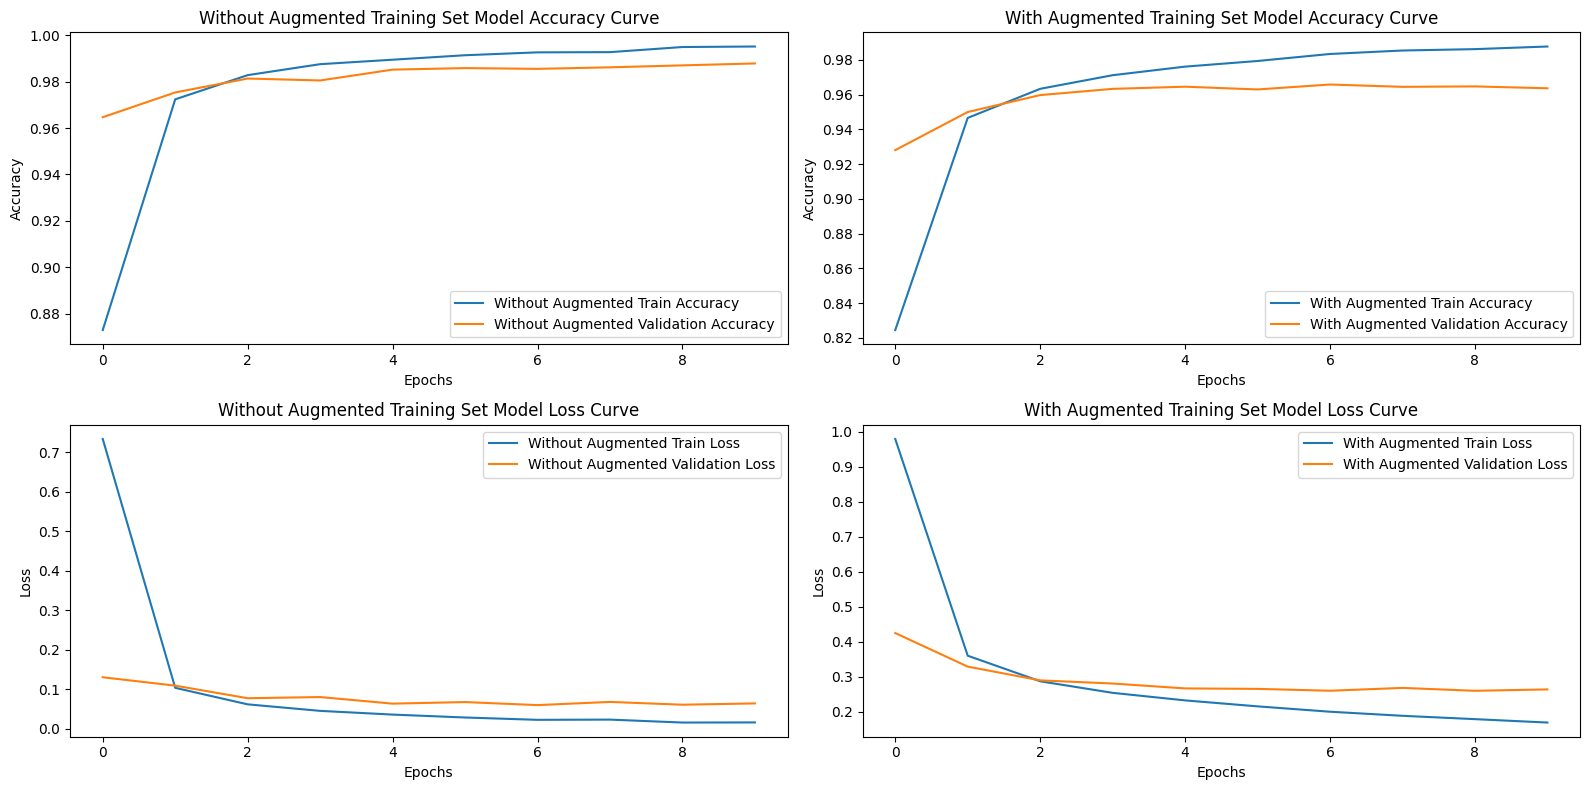

In [21]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(history_original.history['accuracy'], label='Without Augmented Train Accuracy')
plt.plot(history_original.history['val_accuracy'], label='Without Augmented Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Without Augmented Training Set Model Accuracy Curve')


plt.subplot(2, 2, 2)
plt.plot(history_augmented.history['accuracy'], label='With Augmented Train Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='With Augmented Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('With Augmented Training Set Model Accuracy Curve')


plt.subplot(2, 2, 3)
plt.plot(history_original.history['loss'], label='Without Augmented Train Loss')
plt.plot(history_original.history['val_loss'], label='Without Augmented Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Without Augmented Training Set Model Loss Curve')


plt.subplot(2, 2, 4)
plt.plot(history_augmented.history['loss'], label='With Augmented Train Loss')
plt.plot(history_augmented.history['val_loss'], label='With Augmented Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('With Augmented Training Set Model Loss Curve')

plt.tight_layout()
plt.show()


# Testing with and without augmented test set on Without Augmented Train Model

In [22]:
test_loss_orginal_1, test_accuracy_original_1 = model_original.evaluate(test_images, test_labels)
test_loss_augmented_1, test_accuracy_augmented_1 = model_original.evaluate(augmented_test_images, augmented_test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9829 - loss: 0.0702
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9509 - loss: 0.3210


# Testing with and without augmented test set on With Augmented Train Model

In [23]:
test_loss_orginal_2, test_accuracy_original_2 = model_augmented.evaluate(test_images, test_labels)
test_loss_augmented_2, test_accuracy_augmented_2 = model_augmented.evaluate(augmented_test_images, augmented_test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0462
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9829 - loss: 0.0765


# Printing results


In [24]:
print('\n ------------- Without Augmented Training Set Model Test results --------------\n')
print(f'Without Augmented Test Accuracy: {test_accuracy_original_1:.4f}')
print(f'With Augmented Test Accuracy: {test_accuracy_augmented_1:.4f}')

print('\n ------------- With Augmented Training Set Model Test results --------------\n')
print(f'Without Augmented Test Accuracy: {test_accuracy_original_2:.4f}')
print(f'With Augmented Test Accuracy: {test_accuracy_augmented_2:.4f}')


 ------------- Without Augmented Training Set Model Test results --------------

Without Augmented Test Accuracy: 0.9862
With Augmented Test Accuracy: 0.9061

 ------------- With Augmented Training Set Model Test results --------------

Without Augmented Test Accuracy: 0.9907
With Augmented Test Accuracy: 0.9653
